In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as pyplot
import matplotlib.pyplot as plt
import os

In [5]:
# Face detection and cropping function
def detect_and_crop_face(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

    if len(faces) == 0:
        raise NameError("No face detected in the image.")

    for (x, y, w, h) in faces:
        face_crop = gray_image[y:y + h, x:x + w]
        return face_crop

    return None

In [6]:
# Function to compute the magnitude of optical flow in each 8x8 pixel block
def get_magnitude(u, v):
    scale = 3
    sum = 0.0
    counter = 0.0
    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1], 8):
            counter += 1
            dy = v[i, j] * scale
            dx = u[i, j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            sum += magnitude
    mag_avg = sum / counter
    return mag_avg

In [7]:
# Function to draw quiver plot for optical flow vectors (One Plot)
def draw_quiver(u, v, beforeImg):
    scale = 3
    ax = pyplot.figure().gca()
    ax.imshow(beforeImg, cmap='gray')

    magnitudeAvg = get_magnitude(u, v)

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1], 8):
            dy = v[i, j] * scale
            dx = u[i, j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            # Draw only significant changes
            if magnitude > magnitudeAvg:
                ax.arrow(j, i, dx, dy, color='red')

    pyplot.draw()
    pyplot.show()

In [8]:
def resize_images(image1, image2):
    # Get the smaller dimensions
    min_height = min(image1.shape[0], image2.shape[0])
    min_width = min(image1.shape[1], image2.shape[1])

    # Resize both images to the smallest dimensions
    resized_img1 = cv2.resize(image1, (min_width, min_height), interpolation=cv2.INTER_AREA)
    resized_img2 = cv2.resize(image2, (min_width, min_height), interpolation=cv2.INTER_AREA)

    return resized_img1, resized_img2

In [9]:
# Function to compute image derivatives along x, y, and time
def get_derivatives(img1, img2):
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = cv2.filter2D(img1, -1, x_kernel) + cv2.filter2D(img2, -1, x_kernel)
    fy = cv2.filter2D(img1, -1, y_kernel) + cv2.filter2D(img2, -1, y_kernel)
    ft = cv2.filter2D(img1, -1, -t_kernel) + cv2.filter2D(img2, -1, t_kernel)

    return [fx, fy, ft]

In [10]:
# Function to compute Horn-Schunck optical flow with face detection
def computeHS_with_face_detection(image1, image2, alpha, delta, draw= True):
    # Read the images

    #Detect and crop the face from both images
    beforeFace = detect_and_crop_face(image1)
    afterFace = detect_and_crop_face(image2)

    if beforeFace is None or afterFace is None:
       raise NameError("No face detected in one or both images.")

    beforeFace = beforeFace.astype(float)
    afterFace = afterFace.astype(float)

    # Removing noise
    beforeFace = cv2.GaussianBlur(beforeFace, (5, 5), 0)
    afterFace = cv2.GaussianBlur(afterFace, (5, 5), 0)

    #resize
    beforeFace, afterFace = resize_images(beforeFace, afterFace)

    # Initialize optical flow vectors
    u = np.zeros(beforeFace.shape)
    v = np.zeros(beforeFace.shape)

    # Compute image derivatives
    fx, fy, ft = get_derivatives(beforeFace, afterFace)

    # Horn-Schunck algorithm iterations
    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                           [1 / 6, 0, 1 / 6],
                           [1 / 12, 1 / 6, 1 / 12]], float)
    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = cv2.filter2D(u, -1, avg_kernel)
        v_avg = cv2.filter2D(v, -1, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)
        # Convergence check (at most 300 iterations)
        if diff < delta or iter_counter > 300:
            break

    # Draw the optical flow (quiver plot) for the whole face
    if draw:
        draw_quiver(u, v, beforeFace)

    return [u, v]

In [11]:
def calculate_fps(video_path):
    # Open the video file
    video = cv2.VideoCapture(video_path)
    
    # Get the frame rate (FPS)
    fps = video.get(cv2.CAP_PROP_FPS)
    print(f"Frames per second (FPS): {fps}")
    
    # Release the video file
    video.release()
    return fps

Frames per second (FPS): 14.99687565090606
fps:  14.99687565090606


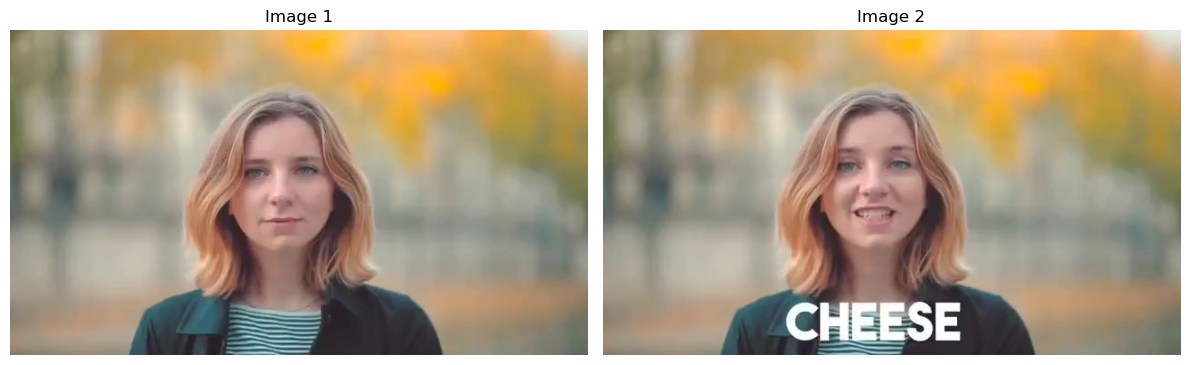

In [12]:
import cv2

# Load the video file
video_path = 'Images/Vid1.mp4'

fps = calculate_fps(video_path)
print("fps: ", fps)
cap = cv2.VideoCapture(video_path)

ret, frame1 = cap.read()
if fps>=45:
    for i in range(16):
        success, frame2 = cap.read()
        if not success:
            raise Exception(f"Error: Could not read frame")

else:
    for i in range(12):
        success, frame2 = cap.read()
        if not success:
            raise Exception(f"Error: Could not read frame")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


image1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

# Display the first image
axes[0].imshow(image1_rgb)
axes[0].set_title('Image 1')
axes[0].axis('off')  # Hide the axis

# Display the second image
axes[1].imshow(image2_rgb)
axes[1].set_title('Image 2')
axes[1].axis('off')  # Hide the axis

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the images
plt.show()

# Display the image
plt.show()
    

# Release video capture object and close display window
cap.release()
cv2.destroyAllWindows()


Frames per second (FPS): 14.99687565090606
fps:  14.99687565090606


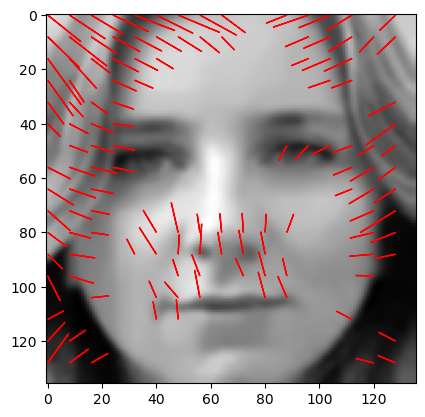

In [13]:
import cv2

# Load the video file
video_path = 'Images/Vid1.mp4'

fps = calculate_fps(video_path)
print("fps: ", fps)
cap = cv2.VideoCapture(video_path)

success, frame1 = cap.read()
if not success:
    raise Exception(f"Error: Could not read frame")

if fps>=45:
    for i in range(16):
        success, frame2 = cap.read()
        if not success:
            raise Exception(f"Error: Could not read frame")

else:
    for i in range(8):
        success, frame2 = cap.read()
        if not success:
            raise Exception(f"Error: Could not read frame")


cap.release()
cv2.destroyAllWindows()


alpha = 15
delta = 10**-1

u, v = computeHS_with_face_detection(frame1, frame2, alpha, delta)

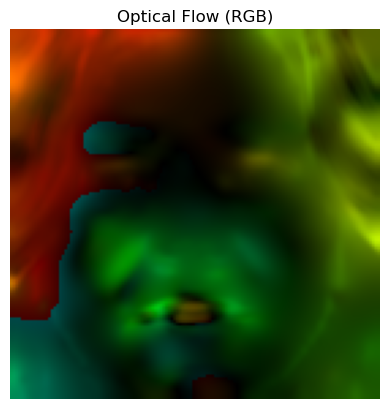

In [14]:

flow_x, flow_y = u, v

# Convert the flow to polar coordinates (magnitude and angle)
magnitude, angle = cv2.cartToPolar(flow_x, flow_y)

# Normalize the magnitude to fit within the range [0, 1]
magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)

# Convert angle to degrees and map to [0, 180] (for hue in HSV)
angle_deg = angle * 180 / np.pi / 2

# Create an HSV image where:
# - Hue represents direction (angle)
# - Saturation is fixed at 1
# - Value represents magnitude (normalized)
hsv = np.zeros((u.shape[0], v.shape[1], 3), dtype=np.float32)
hsv[..., 0] = angle_deg    # Hue (angle of the flow)
hsv[..., 1] = 1            # Saturation (constant full saturation)
hsv[..., 2] = magnitude    # Value (magnitude of the flow)

# Convert the HSV image to RGB for visualization
rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# Show the resulting optical flow visualization
plt.imshow(cv2.cvtColor(rgb_flow, cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV format) to RGB for correct color display
plt.title('Optical Flow (RGB)')  # Add a title to the plot
plt.axis('off')  # Hide axis

# Display the image
plt.show()

Model testing for a video

In [15]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('emotion_classification_model.h5')
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 224, 224, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_conv1 (Conv2D)            │ (None, 224, 224, 64)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,294 (56.38 MB)

 Trainable params: 67,396 (263.27 KB)

 Non-trainable params: 14,712,896 (56.13 MB)

 Optimizer params: 2 (12.00 B)

In [17]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model


emotion_labels = {0: 'neutral', 1: 'sadness', 2: 'fear', 3: 'happiness'}

# Initialize video capture
cap = cv2.VideoCapture('Images/video.mp4')

# Set parameters for optical flow calculation
alpha = 15
delta = 0.1  # Adjust this based on your flow calculation needs

# Read the first frame
ret, previous_frame = cap.read()
if not ret:
    print("Failed to read video")
    cap.release()
    exit()

while cap.isOpened():
    # Capture the next frame
    ret, current_frame = cap.read()
    if not ret:
        break

    # Compute optical flow between the previous and current frames
    u, v = computeHS_with_face_detection(previous_frame, current_frame, alpha, delta, draw=False)

    # Resize and stack u, v components
    u_resized = cv2.resize(u, (224, 224))
    v_resized = cv2.resize(v, (224, 224))
    flow = np.stack((u_resized, v_resized), axis=-1)
    flow = np.expand_dims(flow, axis=0)  # Shape to (1, 224, 224, 2)

    # Predict emotion based on optical flow
    prediction = model.predict(flow)
    predicted_class = np.argmax(prediction)
    predicted_emotion = emotion_labels[predicted_class]

    # Draw a rectangle and put emotion label
    cv2.putText(current_frame, predicted_emotion, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Display the resulting frame
    cv2.imshow('Emotion Detection', current_frame)

    # Press 'q' to quit the video
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Update previous frame
    previous_frame = current_frame.copy()

# Release the capture and close windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 